In [5]:
import numpy as np
import pandas as pd
import pyswarms as ps
from sklearn.metrics import mean_squared_error
from sklearn import neighbors
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support, recall_score, precision_score, f1_score, confusion_matrix, accuracy_score
from sklearn import preprocessing
import seaborn as sn
import matplotlib.pyplot as plt

In [4]:
pip install pyswarms

     |████████████████████████████████| 112kB 6.8MB/s 


In [6]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
os.chdir('/content/gdrive/My Drive/placement/IIBM')
data = pd.read_csv('tumor_data.csv')
label = pd.read_csv('tumor_labels.csv')

In [8]:
X = data.values[:,1:]

#Encode the variable

encode = preprocessing.LabelEncoder()
encode.fit(label.Class.unique())
y = encode.transform(label.Class.values)

In [9]:
### PSO function ###

def pso_feature_selection(X,y):

    ### Change this to NN here ####
    classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
    total_feat = X.shape[1]
    
    # Define objective function
    def f_per_particle(m):

        #total_features = total_feat
        # Get the subset of the features from the binary mask
        if np.count_nonzero(m) == 0:
            X_subset = X
        else:
            X_subset = X[:,m==1]
        # Perform classification and store performance in P
        classifier.fit(X_subset, y)

        # Compute for the objective function
        P = (classifier.score(X_subset,y))
        #j = (alpha * (1.0 - P)+ (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))

        return P


    def f(x):
        n_particles = x.shape[0]
        j = [f_per_particle(x[i]) for i in range(n_particles)]
        return np.array(j)


    options = {'c1': 0.5, 'c2': 0.5, 'w':0.9, 'k': 30, 'p':2}

    # Call instance of PSO
    dimensions = total_feat # dimensions should be the number of features
    #init = np.random.choice([0, 1], size=(10,dimensions), p=[(dimensions-50)/dimensions, 50/dimensions])
    optimizer = ps.discrete.BinaryPSO(n_particles=30, dimensions=dimensions, options=options,init_pos=None)

    # Perform optimization
    cost, pos = optimizer.optimize(f,iters=10,verbose=True)

    return pos

In [10]:
## Cross validation ###

KF = KFold(n_splits=5,shuffle=True)
total_train_accuracy = 0
total_test_accuracy = 0
total_precision = 0
total_recall = 0
total_fscore = 0
final_conf_mat =0

for train_index, test_index in KF.split(X):
    # Split train-test
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #### Feature Selection

    pos = pso_feature_selection(x_test,y_test)
    print('No. of count',np.count_nonzero(pos))

    x1_train = np.array(x_train[:,pos==1]) 
    x1_test = np.array(x_test[:,pos==1]) 

    ### Classification model (ADD NN to be fit here)###

    classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
    classifier.fit(x1_train, y_train)

    y_pred = classifier.predict(x1_test)

    ##### Scoring #########

    print ("Checking on Train Set")
    print ("\nAccuracy on Training Set :"+str(classifier.score(x1_train,y_train)))
    total_train_accuracy += classifier.score(x1_train,y_train)

    print ("Checking on Test Set")
    print ("\nAccuracy on Testing Set :"+str(accuracy_score(y_test,y_pred)))
    total_test_accuracy += accuracy_score(y_test,y_pred)
  
    total_precision+= precision_score(y_test, y_pred,average='macro')
    total_recall+= recall_score(y_test, y_pred,average='macro')	
    total_fscore+= f1_score(y_test, y_pred,average='macro')	
    print ("\nPrecision Score")
    print (precision_score(y_test, y_pred,average='macro'))
    print ("\nRecall Score")
    print (recall_score(y_test, y_pred,average='macro'))	
    print ("\nF1 Score")
    print (f1_score(y_test, y_pred,average='macro'))

    #Confusion Matrix
    conf_mat=confusion_matrix(y_test, y_pred)
    final_conf_mat+=conf_mat
    print("Confusion matrix :\n")
    print(conf_mat)
    

2021-04-22 06:24:37,763 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|10/10, best_cost=0.994
2021-04-22 06:26:02,857 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.9937888198757764, best pos: [1 1 1 ... 1 1 0]


No. of count 10977
Checking on Train Set

Accuracy on Training Set :1.0
Checking on Test Set

Accuracy on Testing Set :0.9875776397515528

Precision Score
0.9885714285714287

Recall Score
0.9889855072463767

F1 Score
0.9885300143525468
Confusion matrix :

[[45  0  0  1  0]
 [ 0 22  0  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 33  0]
 [ 0  0  0  1 29]]


2021-04-22 06:26:08,471 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|10/10, best_cost=0.994
2021-04-22 06:27:31,881 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.99375, best pos: [0 0 1 ... 1 1 0]


No. of count 11770
Checking on Train Set

Accuracy on Training Set :1.0
Checking on Test Set

Accuracy on Testing Set :1.0

Precision Score
1.0

Recall Score
1.0

F1 Score
1.0
Confusion matrix :

[[72  0  0  0  0]
 [ 0 14  0  0  0]
 [ 0  0 27  0  0]
 [ 0  0  0 24  0]
 [ 0  0  0  0 23]]


2021-04-22 06:27:37,487 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|10/10, best_cost=0.994
2021-04-22 06:29:00,760 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.99375, best pos: [1 0 0 ... 0 0 1]


No. of count 11649
Checking on Train Set

Accuracy on Training Set :1.0
Checking on Test Set

Accuracy on Testing Set :0.99375

Precision Score
0.9964285714285716

Recall Score
0.9913043478260869

F1 Score
0.9937537537537537
Confusion matrix :

[[55  0  0  0  0]
 [ 0 15  0  0  0]
 [ 0  0 34  0  0]
 [ 1  0  0 22  0]
 [ 0  0  0  0 33]]


2021-04-22 06:29:05,613 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|10/10, best_cost=0.994
2021-04-22 06:30:30,233 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.99375, best pos: [1 1 0 ... 1 0 1]


No. of count 11553
Checking on Train Set

Accuracy on Training Set :1.0
Checking on Test Set

Accuracy on Testing Set :0.975

Precision Score
0.984317617866005

Recall Score
0.9639003539704802

F1 Score
0.9735822952876289
Confusion matrix :

[[62  0  0  0  0]
 [ 0 13  0  1  0]
 [ 1  0 29  0  0]
 [ 1  0  0 30  0]
 [ 1  0  0  0 22]]


2021-04-22 06:30:35,987 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.5, 'w': 0.9, 'k': 30, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|10/10, best_cost=0.994
2021-04-22 06:32:01,758 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.99375, best pos: [0 1 0 ... 0 0 0]


No. of count 10877
Checking on Train Set

Accuracy on Training Set :1.0
Checking on Test Set

Accuracy on Testing Set :0.99375

Precision Score
0.9969696969696968

Recall Score
0.9933333333333334

F1 Score
0.9950834519342735
Confusion matrix :

[[65  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 25  0  0]
 [ 1  0  0 29  0]
 [ 0  0  0  0 27]]


Mean train accuracy : 100.00
Mean test accuracy : 99.00
Mean precision : 99.33
Mean recall : 98.75
Mean fscore : 99.02
Confusion matrix : 
[[299   0   0   1   0]
 [  0  77   0   1   0]
 [  1   0 145   0   0]
 [  3   0   0 138   0]
 [  1   0   0   1 134]]


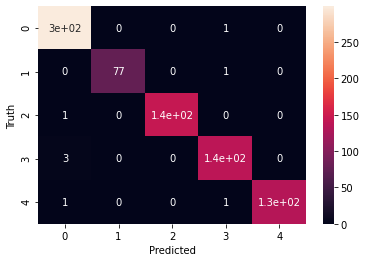

In [11]:
print("Mean train accuracy : %.2f" % ((total_train_accuracy/5)*100))
print("Mean test accuracy : %.2f" % ((total_test_accuracy/5)*100))
print("Mean precision : %.2f" % ((total_precision/5)*100))
print("Mean recall : %.2f" % ((total_recall/5)*100))
print("Mean fscore : %.2f" % ((total_fscore/5)*100))

print("Confusion matrix : " )
print(final_conf_mat)
#plt.figure(figsize=(5,5))
sn.heatmap(final_conf_mat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()